# 深度学习实验三:多层感知机编程

本次实验练习使用torch.nn中的类设计一个多层感知机，并进行训练和测试。
同时练习使用Dataset和Dataloader辅助Mini-Batch随机梯度下降法对模型进行训练。

In [1]:
name = '王浩南'#填写你的姓名
sid = 'E02014154'#填写你的学号

print('姓名:%s, 学号:%s'%(name, sid))

姓名:王浩南, 学号:E02014154


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. 准备数据集

本实验使用MNIST数据集，并用dataloader加载器，从数据集中采样出小批量样本。

In [3]:
from torchvision import datasets,transforms

In [4]:
data_path = '../data/'
mnist_train = datasets.MNIST(data_path,download=False,train = True,transform = transforms.ToTensor())
mnist_test =  datasets.MNIST(data_path,download=False,train = False,transform = transforms.ToTensor())

In [5]:
#看一下mnist_train的内容
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
len(mnist_train)

60000

In [7]:
#为mnist_train 构造一个迭代器
it_mnist_train = iter(mnist_train)

In [8]:
#观察mnist_train中的元素
next(it_mnist_train)#返回一个tuple，包含一张图像以及对应的label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [9]:
img,label = next(it_mnist_train)

In [10]:
#img是一个1*28*28的张量
img.shape

torch.Size([1, 28, 28])

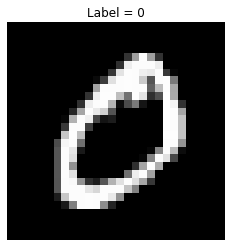

In [11]:
plt.imshow(img[0],cmap = 'gray')
plt.axis('off')
plt.title('Label = %d'%(label))
plt.show()

In [12]:
#查看样本的取值范围
print('Max = ',img.max().item(),',  Min=',img.min().item())

Max =  1.0 ,  Min= 0.0


下面为mnist_train构造一个加载器

In [13]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 32, shuffle = True)

In [14]:
#用加载器加载一批样本
images,labels = next(iter(train_loader))

In [15]:
images.shape

torch.Size([32, 1, 28, 28])

In [16]:
labels.shape

torch.Size([32])

下面展示这一批样本及其对应的label

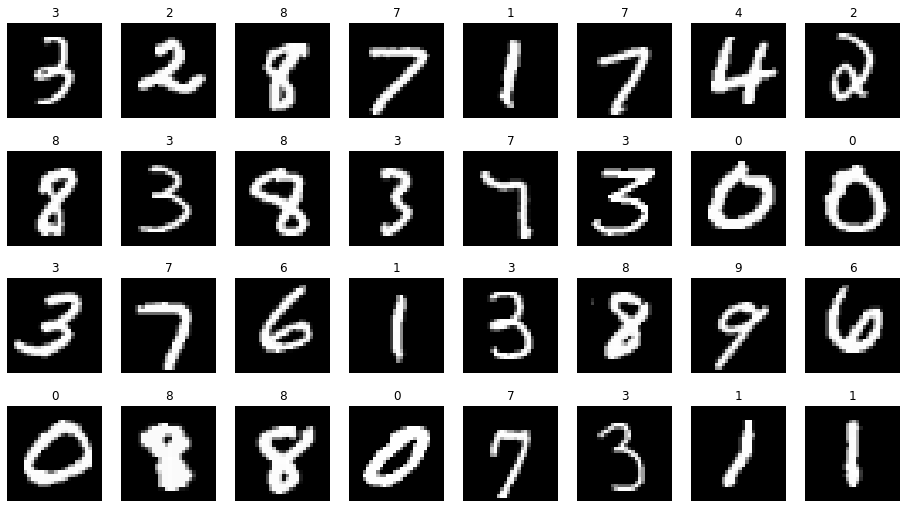

In [17]:
plt.figure(figsize = (16,9))
for k in range(labels.shape[0]):
    plt.subplot(4,8,k+1)
    plt.imshow(images[k].squeeze(),cmap = 'gray')
    plt.axis('off')
    plt.title('%d'%(labels[k]))
plt.show()

# 2. 设计MLP

从torch.nn.Module派生一个子类，表示一个MLP;

你设计的MLP至少包含两个隐层，输出层神经元数目为10，表示10个不同数字类别

注意，网络的输入是$n\times784$的二维张量，每一行表示一个样本。

In [18]:
#在下面添加代码，实现一个表示多层感知机的类MLP,用于识别MNIST手写体数字
class MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__() #调用父类的构造函数
        #定义对象属性
        # 第一个隐层：输入784维，输出512维
        self.fc1 = nn.Linear(in_features, 512, bias = True)
   
        # 第二个隐层：输入512维，输出256维
        self.fc2 = nn.Linear(512, 256, bias = True)

        # 第三个隐层：输入256维，输出128维
        self.fc3 = nn.Linear(256, 128, bias = True)
        
        # 输出层：输入128维，输出10维，表示10个不同数字类别
        self.fc4 = nn.Linear(128, out_features, bias = True)

    def forward(self, x):
        # 第一个隐层：输入x，输出a1
        a1 = F.relu(self.fc1(x))
      
        # 第二个隐层：输入a1，输出a2
        a2 = F.relu(self.fc2(a1))

        # 第三个隐层：输入a2，输出a3
        a3 = F.relu(self.fc3(a2))
        
        # 输出层：输入a3，输出y
        y = F.softmax(self.fc4(a3), dim = 1)
        return y

In [19]:
#测试MLP类
X = torch.rand((10,784),dtype = torch.float32)
net = MLP(784,10)   #构造MLP类的实例为 net
Y = net(X)
print(Y)
net

tensor([[0.0926, 0.0977, 0.0959, 0.0946, 0.1105, 0.1008, 0.1007, 0.1014, 0.1108,
         0.0950],
        [0.0937, 0.0972, 0.0936, 0.0949, 0.1096, 0.1012, 0.1004, 0.1032, 0.1105,
         0.0957],
        [0.0928, 0.0980, 0.0947, 0.0955, 0.1100, 0.1005, 0.1024, 0.1019, 0.1094,
         0.0948],
        [0.0935, 0.0985, 0.0931, 0.0950, 0.1101, 0.1001, 0.1017, 0.1023, 0.1108,
         0.0948],
        [0.0928, 0.0988, 0.0948, 0.0951, 0.1081, 0.1019, 0.1015, 0.1024, 0.1096,
         0.0950],
        [0.0919, 0.1004, 0.0944, 0.0947, 0.1108, 0.1012, 0.0999, 0.1025, 0.1102,
         0.0940],
        [0.0939, 0.0990, 0.0934, 0.0943, 0.1094, 0.1017, 0.1013, 0.1025, 0.1095,
         0.0950],
        [0.0925, 0.0979, 0.0938, 0.0959, 0.1095, 0.1015, 0.1020, 0.1031, 0.1095,
         0.0943],
        [0.0940, 0.0991, 0.0948, 0.0963, 0.1082, 0.1019, 0.0997, 0.1044, 0.1084,
         0.0931],
        [0.0917, 0.0991, 0.0934, 0.0954, 0.1111, 0.1017, 0.1013, 0.1037, 0.1092,
         0.0934]], grad_fn=<

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

```nn.Module```的方法parameters(）返回模型中的所有参数张量，named_parameters()返回模型中的参数名称以及对应的参数。请对上面定义的网络模型，调用这两个方法获取它的参数名称和参数大小(Tensor.size()函数)。

In [20]:
net.parameters()#得到一个生成器

<generator object Module.parameters at 0x0000025FB453CD60>

In [21]:
#通过枚举该生成器可以获得每一个参数
next(net.parameters())

Parameter containing:
tensor([[-0.0074, -0.0289, -0.0250,  ...,  0.0136,  0.0021, -0.0141],
        [-0.0296,  0.0183,  0.0249,  ..., -0.0181,  0.0296,  0.0012],
        [-0.0327, -0.0100,  0.0325,  ...,  0.0097, -0.0354,  0.0048],
        ...,
        [-0.0070,  0.0194, -0.0204,  ..., -0.0015,  0.0285, -0.0274],
        [-0.0033, -0.0285, -0.0009,  ...,  0.0333,  0.0289,  0.0094],
        [-0.0133, -0.0257,  0.0220,  ...,  0.0343,  0.0055,  0.0336]],
       requires_grad=True)

In [22]:
net.named_parameters()#得到一个生成器

<generator object Module.named_parameters at 0x0000025FB5F83580>

In [23]:
#通过枚举该生成器可以获得每一个参数的名字和张量
param = next(net.named_parameters())
param

('fc1.weight',
 Parameter containing:
 tensor([[-0.0074, -0.0289, -0.0250,  ...,  0.0136,  0.0021, -0.0141],
         [-0.0296,  0.0183,  0.0249,  ..., -0.0181,  0.0296,  0.0012],
         [-0.0327, -0.0100,  0.0325,  ...,  0.0097, -0.0354,  0.0048],
         ...,
         [-0.0070,  0.0194, -0.0204,  ..., -0.0015,  0.0285, -0.0274],
         [-0.0033, -0.0285, -0.0009,  ...,  0.0333,  0.0289,  0.0094],
         [-0.0133, -0.0257,  0.0220,  ...,  0.0343,  0.0055,  0.0336]],
        requires_grad=True))

In [24]:
#param的类型是Parameter
param = next(net.parameters())
type(param)

torch.nn.parameter.Parameter

In [25]:
#Parameter.data是真正存储权重的张量
param.data

tensor([[-0.0074, -0.0289, -0.0250,  ...,  0.0136,  0.0021, -0.0141],
        [-0.0296,  0.0183,  0.0249,  ..., -0.0181,  0.0296,  0.0012],
        [-0.0327, -0.0100,  0.0325,  ...,  0.0097, -0.0354,  0.0048],
        ...,
        [-0.0070,  0.0194, -0.0204,  ..., -0.0015,  0.0285, -0.0274],
        [-0.0033, -0.0285, -0.0009,  ...,  0.0333,  0.0289,  0.0094],
        [-0.0133, -0.0257,  0.0220,  ...,  0.0343,  0.0055,  0.0336]])

In [26]:
#使用net.parameters()获取和输出net中的所有参数张量的大小
#大约2行代码
for param in net.parameters():
    print(param.size())

torch.Size([512, 784])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [27]:
#使用net.named_parameters()获得net中的所有参数的名字和大小
#大约2行代码
for name, param in net.named_parameters():
    print(name.ljust(15), param.size())

fc1.weight      torch.Size([512, 784])
fc1.bias        torch.Size([512])
fc2.weight      torch.Size([256, 512])
fc2.bias        torch.Size([256])
fc3.weight      torch.Size([128, 256])
fc3.bias        torch.Size([128])
fc4.weight      torch.Size([10, 128])
fc4.bias        torch.Size([10])


```nn.Module```有一个对象属性```_parameters```，使用一个OrderedDict包含了所有参数。可以直接从这个属性获得模型的参数字典

In [28]:
#直接获取MLP中的参数属性_parameters
net._parameters

OrderedDict()

```nn.Module```的成员发给```modules()```和```named_modules()```, 分别返回模型的子模块以及命名子模块

In [29]:
net.modules()

<generator object Module.modules at 0x0000025FB5F83D60>

In [30]:
next(net.modules())

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [31]:
net.named_modules()

<generator object Module.named_modules at 0x0000025FB5F83F90>

In [32]:
next(net.named_modules())

('',
 MLP(
   (fc1): Linear(in_features=784, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=128, bias=True)
   (fc4): Linear(in_features=128, out_features=10, bias=True)
 ))

In [33]:
#输出MLP中的子模块:
#大约2行代码
for mode in net.modules():
    print(mode)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)
Linear(in_features=784, out_features=512, bias=True)
Linear(in_features=512, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=10, bias=True)


In [34]:
#获取MLP中的命名子模块
#大约2行代码
for named_mode in net.named_modules():
    print(named_mode)

('', MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
))
('fc1', Linear(in_features=784, out_features=512, bias=True))
('fc2', Linear(in_features=512, out_features=256, bias=True))
('fc3', Linear(in_features=256, out_features=128, bias=True))
('fc4', Linear(in_features=128, out_features=10, bias=True))


也可通过```nn.Module```的对象属性```_modules```获得模型的所有子模块。

In [35]:
#直接通过属性_modules获取MLP中的子模块
net._modules

OrderedDict([('fc1', Linear(in_features=784, out_features=512, bias=True)),
             ('fc2', Linear(in_features=512, out_features=256, bias=True)),
             ('fc3', Linear(in_features=256, out_features=128, bias=True)),
             ('fc4', Linear(in_features=128, out_features=10, bias=True))])

```net._modules```是一个有序字典，因此可以使用关键字访问字典的元素，关键字是各个子模块的名字。比如'fc1',可以通过'fc1'这个关键字获取对应的子模块:```net_modules['fc1']```.

In [36]:
#在下面输出net对象的第一个子模块的'weight'参数
#大约一行代码
print(next(net.named_parameters())) # 输出fc1.weight参数作对比
print("{:=^70s}".format(""))  # 分割线
print(net._modules['fc1'].weight) # 输出net对象的第一个子模块的'weight'参数

('fc1.weight', Parameter containing:
tensor([[-0.0074, -0.0289, -0.0250,  ...,  0.0136,  0.0021, -0.0141],
        [-0.0296,  0.0183,  0.0249,  ..., -0.0181,  0.0296,  0.0012],
        [-0.0327, -0.0100,  0.0325,  ...,  0.0097, -0.0354,  0.0048],
        ...,
        [-0.0070,  0.0194, -0.0204,  ..., -0.0015,  0.0285, -0.0274],
        [-0.0033, -0.0285, -0.0009,  ...,  0.0333,  0.0289,  0.0094],
        [-0.0133, -0.0257,  0.0220,  ...,  0.0343,  0.0055,  0.0336]],
       requires_grad=True))
Parameter containing:
tensor([[-0.0074, -0.0289, -0.0250,  ...,  0.0136,  0.0021, -0.0141],
        [-0.0296,  0.0183,  0.0249,  ..., -0.0181,  0.0296,  0.0012],
        [-0.0327, -0.0100,  0.0325,  ...,  0.0097, -0.0354,  0.0048],
        ...,
        [-0.0070,  0.0194, -0.0204,  ..., -0.0015,  0.0285, -0.0274],
        [-0.0033, -0.0285, -0.0009,  ...,  0.0333,  0.0289,  0.0094],
        [-0.0133, -0.0257,  0.0220,  ...,  0.0343,  0.0055,  0.0336]],
       requires_grad=True)


也可以直接用你在上面的类定义中的对象属性来访问模型中的子模块：比如，你在初始化函数中定义了一个线性层：self.lin = Linear(....)。你可以使用lin这个属性获取这个线性层。

```Linear```等网络层都有一个权重参数weight，你可以直接使用net.lin.weight获取到这个参数。

In [37]:
#在下面输出net对象的第一层的权重参数
#大约一行代码
print(net.fc1.weight)

Parameter containing:
tensor([[-0.0074, -0.0289, -0.0250,  ...,  0.0136,  0.0021, -0.0141],
        [-0.0296,  0.0183,  0.0249,  ..., -0.0181,  0.0296,  0.0012],
        [-0.0327, -0.0100,  0.0325,  ...,  0.0097, -0.0354,  0.0048],
        ...,
        [-0.0070,  0.0194, -0.0204,  ..., -0.0015,  0.0285, -0.0274],
        [-0.0033, -0.0285, -0.0009,  ...,  0.0333,  0.0289,  0.0094],
        [-0.0133, -0.0257,  0.0220,  ...,  0.0343,  0.0055,  0.0336]],
       requires_grad=True)


# 3.训练模型

# 3.1 第一步，对数据做预处理

MNIST图像的像素取值范围是[0,1]，先把值域改变为[-1,1]. 在PyTorch中，可以使用torchvision.transforms.Normalize类处理。

In [38]:
from torchvision.transforms import Normalize as normalize

In [39]:
#查看img的最大最小值：
img.min(),img.max()

(tensor(0.), tensor(1.))

In [40]:
#构造一个图像归一化对象normalizer，将图像像素值归一化到[-1,1]区间
#一行代码
normalizer = normalize(0.5,0.5)

In [41]:
#测试normalizer
normalized_img = normalizer(img)
normalized_img.min(),normalized_img.max()

(tensor(-1.), tensor(1.))

# 3.2 第二步，构造训练集，加入预处理

In [42]:
data_path = '../data/'
mnist_train = datasets.MNIST(data_path,download=False,train = True,transform = transforms.Compose([transforms.ToTensor(),normalizer]))
mnist_test =  datasets.MNIST(data_path,download=False,train = False,transform = transforms.Compose([transforms.ToTensor(),normalizer]))

# 3.3 第三步，构造加载器

In [43]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = 32, shuffle = False)

# 3.4 第四步，训练模型

训练模型的过程包含两层循环，第一层是轮次(epoch)循环，每一次循环遍历一次整个训练样本集；第二层是小批次循环，每一次循环从加载器中加载一个小批次样本，用于训练模型，完成一次迭代。

一次迭代包含以下步骤：
1. 梯度清零。调用优化器的zero_grad()函数
2. 前向传播。调用模型对当前批次的样本做预测
3. 计算损失。根据预测结果与真实label计算损失
4. 后向传播。调用损失张量的backward()函数，更新模型权重的梯度
5. 梯度下降。调用优化器的step()函数，更新权重参数。

In [44]:
#请在下面定义一个训练模型的函数Train:

def Train(model, loader, epochs, lr = 0.1):

    '''
        参数说明：
        model:模型对象；
        loader：样本加载器;
        epochs：轮次;
        lr：学习率
    '''
    epsilon = 1e-6#损失收敛条件
    
    #首先调用模型的train函数，进入train模式
    model.train()
    
    #在下面定义优化器
    optimizer = optim.SGD(model.parameters(), lr=lr) #请用一行代码实现
    
    #在下面定义损失函数（交叉熵损失）:
    loss = nn.CrossEntropyLoss()#请用一行代码实现
    
    loss0 = 0
    for epoch in range(epochs):
        for it,(imgs, labels) in enumerate(loader):
            #1. zero_grads
            #请用一行代码实现
            optimizer.zero_grad()
            
            #2. F.P.前向传播
            #请用一行代码实现
            # torch.Size([32, 1, 28, 28]) -> 32张 1通道 28*28尺寸的图片 使用view将其转换成1*784的张量
            # imgs.shape[0] = 32    imgs.shape[1] = 1   imgs.shape[2] = 28  imgs.shape[3] = 28 
            logits = model.forward(imgs.view(imgs.shape[0],28*28))

            #3. 计算损失
            #请用一行代码实现            
            loss1 = loss(logits, labels)
            
            if(abs(loss1.item() - loss0) < epsilon):
                break
                
            loss0 = loss1.item()
                
            if it%100==0:
                print('epoch %d, iter %d, loss = %f\n'%(epoch,it,loss1.item()))

                
            #4. 后向传播
            #请用一行代码实现
            loss1.backward()
            
            #5. 梯度下降
            #请用一行代码实现.
            optimizer.step()

    return model            

In [45]:
#训练模型

model = MLP(784, 10)
#为了尽快训练模型，这里使用测试集训练10轮，你可以修改轮次和学习率

model = Train(model, test_loader, 10, 0.1)


epoch 0, iter 0, loss = 2.302688

epoch 0, iter 100, loss = 2.293635

epoch 0, iter 200, loss = 2.232348

epoch 0, iter 300, loss = 2.067779

epoch 1, iter 0, loss = 1.990672

epoch 1, iter 100, loss = 1.779883

epoch 1, iter 200, loss = 1.759027

epoch 1, iter 300, loss = 1.747147

epoch 2, iter 0, loss = 1.709334

epoch 2, iter 100, loss = 1.612717

epoch 2, iter 200, loss = 1.666198

epoch 2, iter 300, loss = 1.683929

epoch 3, iter 0, loss = 1.583854

epoch 3, iter 100, loss = 1.564201

epoch 3, iter 200, loss = 1.640739

epoch 3, iter 300, loss = 1.673183

epoch 4, iter 0, loss = 1.586137

epoch 4, iter 100, loss = 1.553959

epoch 4, iter 200, loss = 1.630205

epoch 4, iter 300, loss = 1.658134

epoch 5, iter 0, loss = 1.584700

epoch 5, iter 100, loss = 1.586375

epoch 5, iter 200, loss = 1.699188

epoch 5, iter 300, loss = 1.658579

epoch 6, iter 0, loss = 1.574380

epoch 6, iter 100, loss = 1.579872

epoch 6, iter 200, loss = 1.673392

epoch 6, iter 300, loss = 1.645877

epoch 

# 3.5 第五步，测试模型

请编写一个用于评估模型分类准确率的函数Evaluate。使用给定的数据加载器，对模型的预测结果与真实label进行比对，计算出模型的准确率。

In [46]:
#编写模型测试过程
def Evaluate(model, loader):
    '''
    参数说明：
    model:待测试的模型
    loader：数据加载器
    返回值为模型的预测准确率
    '''
    #进入评估模式:
    #一行代码
    model.eval()
    
    
    correct = 0#用于累加每一次循环中预测的正确样本数
    counts = 0#用于累加参与测试的样本总数
    
    #在下面编写代码，从loader中加载样本，使用model预测，然后统计预测正确的样本数量
    with torch.no_grad():
        for imgs, labels in test_loader:
            batch_size = imgs.shape[0]
            logits = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(logits.data, dim = 1)
            counts += batch_size
            correct += (predicted == labels).sum().item()
    
    #计算准确率
    accuracy = correct / counts
    
    return accuracy

In [47]:
#使用test_loader评估模型的准确率
acc = Evaluate(model,test_loader)
print('Accuracy = %f'%(acc))

Accuracy = 0.862500


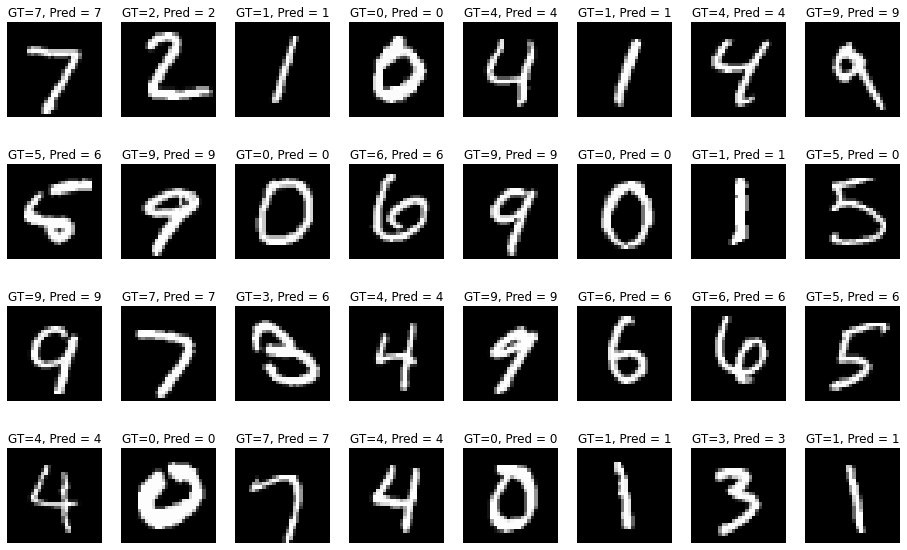

In [48]:
#展示预测结果实例

imgs,labels  = next(iter(test_loader))

logits = model(imgs.view(imgs.size(0),-1))
yhat = logits.argmax(dim = 1)

plt.figure(figsize = (16,10))
for i in range(imgs.size(0)):
    plt.subplot(4,8,i+1)
    plt.imshow(imgs[i].squeeze()/2+0.5,cmap = 'gray')
    plt.axis('off')
    plt.title('GT=%d, Pred = %d'%(labels[i],yhat[i]))
    
plt.show()

# 4. 可视化模型（选做）

## 4.1 展示第一层神经元权重

你可以把上面训练的模型的第一隐层权值向量可视化展示出来，看看这些神经元学到了什么特征？

使用上面第2节介绍的模型参数的有关内容，获取模型第一隐层的权重张量，并将每一个神经元的权重(784维向量)转换为28*28大小的矩阵，并归一化到（0，1）范围，便于展示。

使用matplotlit.pyplot.imshow函数展示权重图像。

可以只选取少量神经元的权重予以展示。

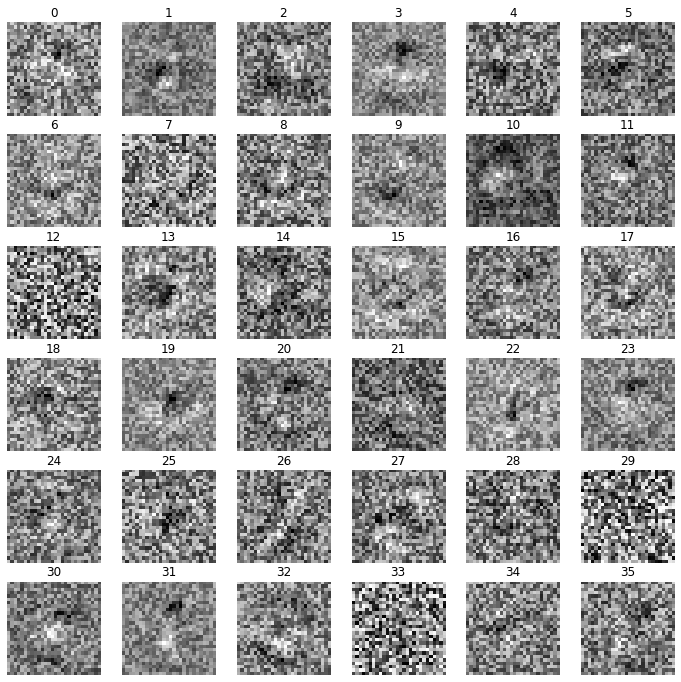

In [49]:
#在下面编写代码获取权重张量并展示出来

# 获取模型第一隐层的权重张量
weights = model.fc1.weight.data

# 选取少量神经元的权重, 选取36个
weights = weights[:36]

# 将每一个神经元的权重(784维向量)转换为28*28大小的矩阵，并归一化到（0，1）范围
weights = weights.view(weights.size(0), 28, 28)
weights = weights / weights.max()

# 使用matplotlit.pyplot.imshow函数展示权重图像
#设置图像尺寸
plt.figure(figsize = (12,12)) 
#遍历神经元
for i in range(weights.size(0)):
    plt.subplot(6, 6, i + 1)
    plt.axis('off')
    plt.imshow(weights[i], cmap='gray')
    plt.title(i)

plt.show()


## 4.2 展示隐含层神经元对不同样本的响应

假设隐含层包含n个神经元，给定一个输入样本x，这n个神经元的输出构成了该样本的一个特征表达，即n维特征向量。

如果你的模型经过训练可以很好的区分不同数字，那么不同类别的样本的这些特征向量应该有很明显的差异。

假设你的模型第一个隐层在MLP类中对应的对象属性名为fc1，那么你可以用net.fc1(x)或者x的特征向量。

更高层的特征向量参考你编写的forward函数中的写法获取。

下面选取少量数字样本，输出你训练的模型中某一个隐含层得到的特征向量。

使用matplotlit.pyplot.plot方式把每一个特征向量绘制为一个曲线图。

In [50]:
#在下面编写代码